In [8]:
import os
import shutil
from collections import Counter
from timeit import default_timer as timer
%load_ext autoreload
%autoreload 2


# from PIL import Image
# import cv2

!pip install ipywidgets

import seaborn as sns
from matplotlib import pyplot as plt

from typing import List, Tuple
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import engine
import helper_functions


for filename in os.listdir('/kaggle/input'):
    print(filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

alzheimers-dataset-4-class-of-images


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split, StratifiedKFold
from torchinfo import summary
import time

from tempfile import TemporaryDirectory

# cudnn.benchmark = True
# plt.ion() 
print(torch.__version__)

2.1.2


# Setup device agnostic code

In [10]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Merging test-train-valid directories

As we observed during data exploration the test and valid directories are not balanced although the train directory is. We decided to merge all the directories in one directory destination_dir = '/kaggle/working/all', perform cross-validation and evaluate the model using balanced accuracy.


In [11]:
# Define the directory path to check
directory_to_check = 'merged_dataset'
#all_directory= '/content/Alzheimer_s Dataset'

# Check if the directory exists
if not os.path.exists(directory_to_check):
    # Define the source and destination directories
    source_base_dir = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset'
    destination_dir = 'merged_dataset'

    # List of subdirectories to merge
    subdirectories_to_merge =  ['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']

    # Create the destination directory if it doesn't exist
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    # Loop through each of the train, test, and val directories
    for dataset_dir in ['train', 'test']:
        # Loop through the subdirectories to merge
        for subdirectory in subdirectories_to_merge:
            # Define the source and destination paths
            source_path = os.path.join(source_base_dir, dataset_dir, subdirectory)
            destination_path = os.path.join(destination_dir, subdirectory)

            # Create a directory for the class if it doesn't exist
            if not os.path.exists(destination_path):
                os.makedirs(destination_path)

            # Copy the files from source to destination
            for filename in os.listdir(source_path):
                source_file = os.path.join(source_path, filename)
                destination_file = os.path.join(destination_path, filename)
                shutil.copy(source_file, destination_file)

        # Define the directory path
        all_directory = 'merged_dataset'

    print("Files merged successfully.")

else:
        all_directory ='merged_dataset'
        print("all images are exist")

#/content/Alzheimer_s Dataset/train/MildDemented

            

Files merged successfully.


In [12]:
# List of subdirectories to check
subdirectories_to_check = ['MildDemented',
 'ModerateDemented',
 'NonDemented',
 'VeryMildDemented']

# Loop through the subdirectories
for subdirectory in subdirectories_to_check:
    subdirectory_path = os.path.join(all_directory, subdirectory)

    # Check if the directory exists
    if os.path.exists(subdirectory_path):
        # Count the number of files in the directory
        num_files = len(os.listdir(subdirectory_path))
        print(f"Number of files in '{subdirectory}': {num_files}")
    else:
        print(f"'{subdirectory}' directory does not exist in '{all_directory}'.")

Number of files in 'MildDemented': 896
Number of files in 'ModerateDemented': 64
Number of files in 'NonDemented': 3200
Number of files in 'VeryMildDemented': 2240


In [13]:
transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Load Data and Visualize them

In [14]:
DATA_DIR = all_directory

dataset = ImageFolder(DATA_DIR)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 6400
    Root location: merged_dataset


In [15]:
labels = dataset.targets
dataset.class_to_idx

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

### Plot the classes' distribution

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


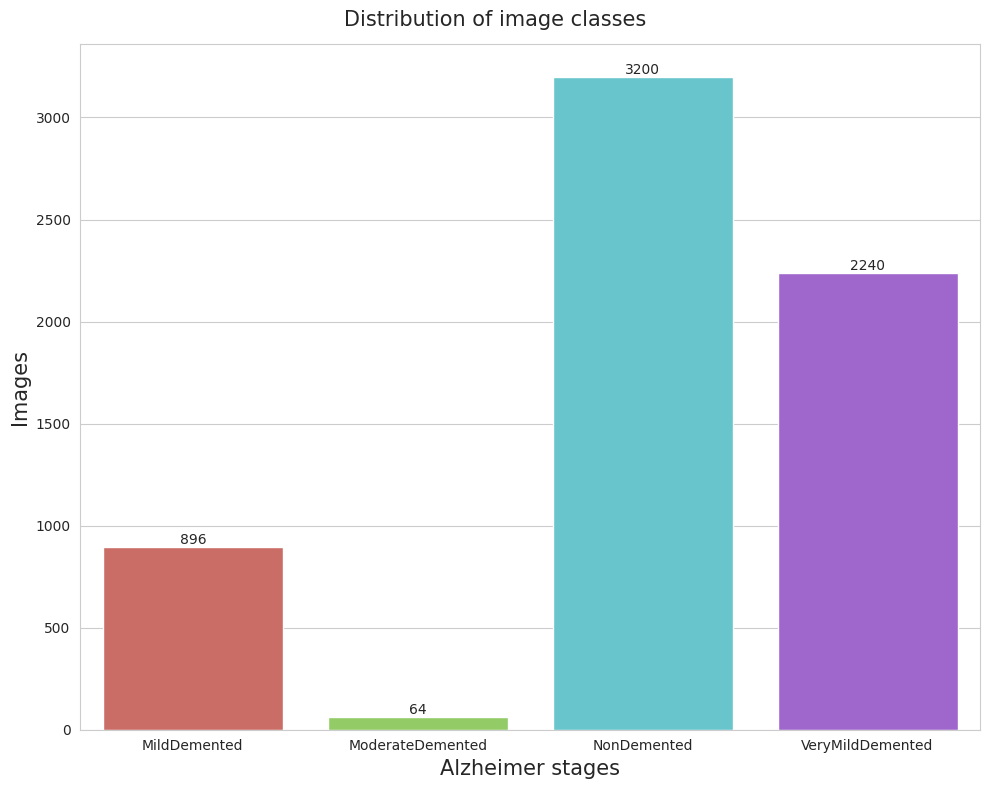

In [18]:
img_per_class = dict(Counter(dataset.targets))

plt.rcParams["figure.autolayout"] = True
plt.figure(figsize=(10,8))
sns.set_style('whitegrid')
ax = sns.barplot(x=dataset.classes, y=[value for value in img_per_class.values()], color='blue', palette='hls')
ax.bar_label(ax.containers[0])

plt.xlabel('Alzheimer stages', fontsize=15)
plt.ylabel(f'Images', fontsize=15)


plt.suptitle(f'Distribution of image classes', fontsize=15)
plt.savefig(f'/kaggle/working/classes_distribution.png')
plt.show()

 ## Split into stratified train,val, test subsets and store into folders (Kiriakos' function)



This function takes the dataset, labels, and specified ratios for training, validation, and testing as inputs, along with an optional random seed set to 42 to control randomness. Firstly, the code checks if the sum of the provided ratios equals 1.0 to ensure a valid configuration.

Next, it performs the initial split using the train_test_split function, dividing the dataset and labels into training and testing sets based on the provided ratios. Then, it calculates the size of the validation set for the second split. The second split is performed on the training data to create separate training and validation sets. The size of the validation set is determined by the formula val_ratio / (train_ratio + val_ratio) in the denominator, considering the adjusted ratio due to the initial split. This ensures that the validation set size is relative to the size of the new training data resulting from the initial split.


In [19]:
def split_dataset(dataset, labels, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_seed=42):
    if train_ratio + val_ratio + test_ratio != 1.0:
        raise ValueError("The sum of train_ratio, val_ratio, and test_ratio should be 1.0")
        
    # initial split
    train_data, test_data, train_labels, test_labels = train_test_split(
        dataset, labels, test_size=test_ratio, random_state=random_seed, stratify=labels)
    remaining_ratio = val_ratio / (train_ratio + val_ratio)
    # rain-validation split
    train_data, val_data, train_labels, val_labels = train_test_split(
        train_data, train_labels, test_size=remaining_ratio, random_state=random_seed, stratify=train_labels)
    
    return train_data, val_data, test_data

# Load pretrained EfficientNet and inspect

Load the EfficientNetb0 model available in torchvision and use the pretrained weights to do transfer learning. Reset final fully connected layer to output the classes of our dataset.

Find the transforms the model used during training.

In [20]:
weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT # .DEFAULT = best available weights
model = torchvision.models.efficientnet_b1(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:02<00:00, 11.3MB/s]


In [21]:
summary(model, 
        input_size=(32, 3, 240, 240), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
       )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 240, 240]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 240, 240]    [32, 1280, 8, 8]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 240, 240]    [32, 32, 120, 120]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 240, 240]    [32, 32, 120, 120]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 120, 120]   [32, 32, 120, 120]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 120, 120]   [32, 32, 120, 120]   --                   --
│    └─Sequential (1)                                        [32, 32, 120, 120]   [32, 16, 120

In [22]:
# Find the tranforms that the prertained model used
transform=weights.transforms()
transform

ImageClassification(
    crop_size=[240]
    resize_size=[255]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

## Reset the final layer according to our number of classes.

In [23]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
class_names = dataset.classes
output_shape = len(class_names)

# get the number of input features for the final layer
num_ftrs = model.classifier[1].in_features

#Reset the final layer
model.classifier[1] = nn.Linear(num_ftrs, output_shape).to(device)
model = model.to(device)

In [24]:
summary(model, 
        input_size=(32, 3, 240, 240), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
       )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 240, 240]    [32, 4]              --                   True
├─Sequential (features)                                      [32, 3, 240, 240]    [32, 1280, 8, 8]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 240, 240]    [32, 32, 120, 120]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 240, 240]    [32, 32, 120, 120]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 120, 120]   [32, 32, 120, 120]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 120, 120]   [32, 32, 120, 120]   --                   --
│    └─Sequential (1)                                        [32, 32, 120, 120]   [32, 16, 120

# Create a custom EfficientNet object

In [25]:
def create_efficientnetb1_custom(num_classes, seed=42):
  
    # Set random seeds for reproducibility
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    # Load the pretrained EfficientNetB0 model from torchvision
    weights=torchvision.models.EfficientNet_B1_Weights.DEFAULT # .DEFAULT = best available weights
    model = models.efficientnet_b1(weights=weights)

    # Modify the final fully connected layer for the desired number of output classes
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = torch.nn.Linear(num_ftrs, num_classes)
    model.to(device)

    return model

In [26]:
# Example usage:
num_classes = len(dataset.classes)  
custom_efficientnet = create_efficientnetb1_custom(num_classes).to(device)

In [27]:
summary(custom_efficientnet, 
        input_size=(32, 3, 240, 240), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
       )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 240, 240]    [32, 4]              --                   True
├─Sequential (features)                                      [32, 3, 240, 240]    [32, 1280, 8, 8]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 240, 240]    [32, 32, 120, 120]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 240, 240]    [32, 32, 120, 120]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 120, 120]   [32, 32, 120, 120]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 120, 120]   [32, 32, 120, 120]   --                   --
│    └─Sequential (1)                                        [32, 32, 120, 120]   [32, 16, 120

## Load weights if they already exist

In [28]:
# Define your model
loaded_model = custom_efficientnet # Change this to your specific model architecture

# Define the path to the weights file
weights_file_path = "/kaggle/input/efficientnet-final/01_efficientnet_final_model.pth"

# Check if the weights file exists and load them while mapping to CPU
if os.path.exists(weights_file_path):
    state_dict = torch.load(weights_file_path, map_location=torch.device('cpu'))
    custom_efficientnet.load_state_dict(state_dict)
    print("Weights loaded successfully.")
else:
    print(f"Weights file not found at {weights_file_path}. Model initialized with default weights.")


Weights file not found at /kaggle/input/efficientnet-final/01_efficientnet_final_model.pth. Model initialized with default weights.


If the weights already exist we can just use the loaded_model to make predictions just by running `model=loaded_model`!


Otherwise we have to train the model from scratch.

## Define a loss function and an optimizer

We chose to use a weighted cross entropy loss function to factor in the class imbalance. The weights we used are the percentages of images in each class.

In [29]:
total_imgs = len(dataset)
num_classes = len(dataset.classes)
weights = torch.tensor([total_imgs/(class_imgs*num_classes) for class_imgs in img_per_class.values()]).to(device)
print(weights)

# define the CrossEntropyLoss with weights
loss_fn = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.01)

tensor([ 1.7857, 25.0000,  0.5000,  0.7143], device='cuda:0')


# Prepare dataset for cross validation

Load dataset with different transforms for the train and test splits. The transforms used are the ones the pretrained model weights were optimized on. Using the same transforms usually yields better performance when fine-tuning or using the model for feature extraction.

It is important to make sure that all values are scaled to the range [0..1] before we pass them to a neural network - it is the usual convention for data preparation, and all default weight initializations in neural networks are designed to work with this range. The transform.ToTensor() method does this tranformation.

It is important to note that all images should be scaled to the same size. The transform.Resize() method performs bilinear interpolation by default. Since our images are already in the size of 224x224 or smaller we decided not to first resize to 256 and then crop to 224 as the pretrained model suggests, in feat of losing information. We only resized them all to 224x224.

Normalization is done with the ImageNet means and stds.

The test set will be held out separately for testing the final model after cross validation

In [30]:
train_dataset = ImageFolder(DATA_DIR, transform=transform)
test_dataset = ImageFolder(DATA_DIR, transform=transform)

# Create a list of indices from 0 to length of dataset
indices = list(range(len(train_dataset)))

# Retrieve the labels from the dataset
labels = [label for _, label in train_dataset]

# Perform stratified split
train_idx, test_idx = train_test_split(
    indices,
    test_size=0.2,  # 20% test, 80% train
    stratify=labels,
    random_state=42  # To ensure reproducibility
)

# Create train, test data with Subset using the indices generated above
train_subset = Subset(train_dataset, train_idx)
train_targets=[train_dataset.targets[i] for i in train_idx]
train_targets_counts=Counter(train_targets)
print(train_targets_counts, len(train_subset))

test_subset = Subset(test_dataset, test_idx)
test_targets=[test_dataset.targets[i] for i in test_idx]
test_targets_counts=Counter(test_targets)
print(test_targets_counts, len(test_subset))

# Create Test DataLoader
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

Counter({2: 2560, 3: 1792, 0: 717, 1: 51}) 5120
Counter({2: 640, 3: 448, 0: 179, 1: 13}) 1280


## Create dataloaders for 5 stratified folds of the training subset

In [31]:
# First we will create our train and test dataloaders using StratifiedKFold from sklearn

data_loaders = []
class_counts_per_split=[]

reduced_dataset = train_subset

# Perform cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X = [dataset.imgs[i] for i in train_idx]
y = [dataset.targets[i] for i in train_idx]

for i, (train_indices, val_indices) in enumerate(stratified_kfold.split(X, y)):
    # Get the class labels for the training and testing sets of this split
    train_classes = [y[idx] for idx in train_indices]
    val_classes = [y[idx] for idx in val_indices]
    
    # Count the occurrences of each class in the training and testing sets
    train_class_counts = Counter(train_classes)
    val_class_counts = Counter(val_classes)
    
    # Append the counts to the list
    class_counts_per_split.append((f"Split {i+1}", train_class_counts, val_class_counts))

    # Create subsets of the dataset for training and testing using the indices
    train_subset = Subset(reduced_dataset, train_indices)
    val_subset = Subset(reduced_dataset, val_indices)
    
    # Create data loaders for training and testing
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    
    data_loaders.append((train_loader, val_loader))

    # Print class counts for this split
    print(f"Split {i+1}:")
    print("Train Set Class Counts:", train_class_counts)
    print("Val Set Class Counts:", val_class_counts)
    print()
    print("Train DataLoader:", train_loader)
    print("Val DataLoader:", val_loader)
    print()

Split 1:
Train Set Class Counts: Counter({2: 2048, 3: 1433, 0: 574, 1: 41})
Val Set Class Counts: Counter({2: 512, 3: 359, 0: 143, 1: 10})

Train DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7a5fa54827d0>
Val DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7a5fa5483490>

Split 2:
Train Set Class Counts: Counter({2: 2048, 3: 1433, 0: 574, 1: 41})
Val Set Class Counts: Counter({2: 512, 3: 359, 0: 143, 1: 10})

Train DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7a5fa5482140>
Val DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7a5fa5480dc0>

Split 3:
Train Set Class Counts: Counter({2: 2048, 3: 1434, 0: 573, 1: 41})
Val Set Class Counts: Counter({2: 512, 3: 358, 0: 144, 1: 10})

Train DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7a5fa5480fd0>
Val DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7a5fa5480e50>

Split 4:
Train Set Class Counts: Counter({2: 2048, 3: 1434, 0: 573, 1: 41})
Val

In [68]:
print(data_loaders)

[(<torch.utils.data.dataloader.DataLoader object at 0x7cad5c558940>, <torch.utils.data.dataloader.DataLoader object at 0x7cad5c55b460>), (<torch.utils.data.dataloader.DataLoader object at 0x7cad5c559e10>, <torch.utils.data.dataloader.DataLoader object at 0x7cad5c558be0>), (<torch.utils.data.dataloader.DataLoader object at 0x7cad5c558d90>, <torch.utils.data.dataloader.DataLoader object at 0x7cad5c559f90>), (<torch.utils.data.dataloader.DataLoader object at 0x7cad5c558a30>, <torch.utils.data.dataloader.DataLoader object at 0x7cad5c558730>), (<torch.utils.data.dataloader.DataLoader object at 0x7cad5c55ae00>, <torch.utils.data.dataloader.DataLoader object at 0x7cad5c558550>)]


# Perform Cross Validation

We can now evaluate the model using a loop to iterate through our 5 dataloaders. We append the results in `results_all` list 

In [69]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

results_all=[]


for i in range(5):
    print(f"Split:{i}")
    start_time = timer()
    
    # Create default model
    model=create_efficientnetb1_custom(num_classes).to(device)
    
    # Set the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
   
    
    print('Model was reset')
    results, _ = engine.train_with_early_stopping(model=model,
                                                  train_dataloader=data_loaders[i][0],
                                                  valid_dataloader=data_loaders[i][1],
                                                  optimizer=optimizer,
                                                  loss_fn=loss_fn,
                                                  epochs=20,
                                                  device=device)

    results_all.append(results)

    # End the timer and print out how long it took
    end_time = timer()
    print(f"[INFO] Total training time of split {i}: {end_time-start_time:.3f} seconds")

Split:0
Model was reset


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2457 | train_bal_acc: 0.4670 | train_mcc: 0.2149 | valid_loss: 0.9975 | valid_bal_acc: 0.5813 | valid_mcc: 0.3583
Epoch: 2 | train_loss: 0.8603 | train_bal_acc: 0.6113 | train_mcc: 0.3834 | valid_loss: 0.7233 | valid_bal_acc: 0.6365 | valid_mcc: 0.4229
Epoch: 3 | train_loss: 0.6311 | train_bal_acc: 0.7252 | train_mcc: 0.5115 | valid_loss: 0.5618 | valid_bal_acc: 0.7411 | valid_mcc: 0.5203
Epoch: 4 | train_loss: 0.5003 | train_bal_acc: 0.7992 | train_mcc: 0.6169 | valid_loss: 0.4812 | valid_bal_acc: 0.7868 | valid_mcc: 0.5946
Epoch: 5 | train_loss: 0.3537 | train_bal_acc: 0.8586 | train_mcc: 0.7177 | valid_loss: 0.3924 | valid_bal_acc: 0.8256 | valid_mcc: 0.6570
Epoch: 6 | train_loss: 0.2543 | train_bal_acc: 0.9079 | train_mcc: 0.7971 | valid_loss: 0.3666 | valid_bal_acc: 0.8466 | valid_mcc: 0.7219
Epoch: 7 | train_loss: 0.1896 | train_bal_acc: 0.9367 | train_mcc: 0.8557 | valid_loss: 0.3121 | valid_bal_acc: 0.8570 | valid_mcc: 0.7197
Epoch: 8 | train_loss: 0.14

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2561 | train_bal_acc: 0.4654 | train_mcc: 0.2226 | valid_loss: 1.0439 | valid_bal_acc: 0.5114 | valid_mcc: 0.2851
Epoch: 2 | train_loss: 0.8853 | train_bal_acc: 0.6230 | train_mcc: 0.3843 | valid_loss: 0.7596 | valid_bal_acc: 0.6230 | valid_mcc: 0.3789
Epoch: 3 | train_loss: 0.6035 | train_bal_acc: 0.7313 | train_mcc: 0.5121 | valid_loss: 0.5790 | valid_bal_acc: 0.7305 | valid_mcc: 0.5063
Epoch: 4 | train_loss: 0.4373 | train_bal_acc: 0.8161 | train_mcc: 0.6277 | valid_loss: 0.4847 | valid_bal_acc: 0.7851 | valid_mcc: 0.5945
Epoch: 5 | train_loss: 0.3130 | train_bal_acc: 0.8759 | train_mcc: 0.7374 | valid_loss: 0.4307 | valid_bal_acc: 0.8116 | valid_mcc: 0.6736
Epoch: 6 | train_loss: 0.2598 | train_bal_acc: 0.9037 | train_mcc: 0.7976 | valid_loss: 0.3827 | valid_bal_acc: 0.8320 | valid_mcc: 0.7095
Epoch: 7 | train_loss: 0.1874 | train_bal_acc: 0.9372 | train_mcc: 0.8583 | valid_loss: 0.3257 | valid_bal_acc: 0.8574 | valid_mcc: 0.7623
Epoch: 8 | train_loss: 0.14

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2584 | train_bal_acc: 0.4464 | train_mcc: 0.2115 | valid_loss: 1.0623 | valid_bal_acc: 0.5481 | valid_mcc: 0.2902
Epoch: 2 | train_loss: 0.8657 | train_bal_acc: 0.6226 | train_mcc: 0.3839 | valid_loss: 0.6938 | valid_bal_acc: 0.6670 | valid_mcc: 0.4282
Epoch: 3 | train_loss: 0.6104 | train_bal_acc: 0.7343 | train_mcc: 0.5157 | valid_loss: 0.5619 | valid_bal_acc: 0.7369 | valid_mcc: 0.4977
Epoch: 4 | train_loss: 0.4629 | train_bal_acc: 0.8012 | train_mcc: 0.6092 | valid_loss: 0.4760 | valid_bal_acc: 0.7861 | valid_mcc: 0.5921
Epoch: 5 | train_loss: 0.3270 | train_bal_acc: 0.8707 | train_mcc: 0.7315 | valid_loss: 0.4824 | valid_bal_acc: 0.7943 | valid_mcc: 0.6134
Epoch: 6 | train_loss: 0.2469 | train_bal_acc: 0.9094 | train_mcc: 0.8069 | valid_loss: 0.3984 | valid_bal_acc: 0.8416 | valid_mcc: 0.7160
Epoch: 7 | train_loss: 0.1846 | train_bal_acc: 0.9334 | train_mcc: 0.8566 | valid_loss: 0.3808 | valid_bal_acc: 0.8393 | valid_mcc: 0.6830
Epoch: 8 | train_loss: 0.14

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2497 | train_bal_acc: 0.4641 | train_mcc: 0.2173 | valid_loss: 1.0375 | valid_bal_acc: 0.5613 | valid_mcc: 0.3250
Epoch: 2 | train_loss: 0.8551 | train_bal_acc: 0.6277 | train_mcc: 0.3921 | valid_loss: 0.7481 | valid_bal_acc: 0.6514 | valid_mcc: 0.3951
Epoch: 3 | train_loss: 0.5921 | train_bal_acc: 0.7365 | train_mcc: 0.5161 | valid_loss: 0.6032 | valid_bal_acc: 0.7254 | valid_mcc: 0.5215
Epoch: 4 | train_loss: 0.4422 | train_bal_acc: 0.8165 | train_mcc: 0.6375 | valid_loss: 0.5497 | valid_bal_acc: 0.7447 | valid_mcc: 0.5307
Epoch: 5 | train_loss: 0.3454 | train_bal_acc: 0.8585 | train_mcc: 0.7148 | valid_loss: 0.4321 | valid_bal_acc: 0.8090 | valid_mcc: 0.6613
Epoch: 6 | train_loss: 0.2350 | train_bal_acc: 0.9168 | train_mcc: 0.8204 | valid_loss: 0.4117 | valid_bal_acc: 0.8193 | valid_mcc: 0.6784
Epoch: 7 | train_loss: 0.1763 | train_bal_acc: 0.9346 | train_mcc: 0.8551 | valid_loss: 0.3627 | valid_bal_acc: 0.8639 | valid_mcc: 0.7534
Epoch: 8 | train_loss: 0.15

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2530 | train_bal_acc: 0.4515 | train_mcc: 0.2102 | valid_loss: 1.0716 | valid_bal_acc: 0.5817 | valid_mcc: 0.3673
Epoch: 2 | train_loss: 0.8789 | train_bal_acc: 0.6283 | train_mcc: 0.3862 | valid_loss: 0.7354 | valid_bal_acc: 0.6700 | valid_mcc: 0.4333
Epoch: 3 | train_loss: 0.6013 | train_bal_acc: 0.7340 | train_mcc: 0.5121 | valid_loss: 0.5973 | valid_bal_acc: 0.7384 | valid_mcc: 0.5434
Epoch: 4 | train_loss: 0.4527 | train_bal_acc: 0.8142 | train_mcc: 0.6385 | valid_loss: 0.5254 | valid_bal_acc: 0.7666 | valid_mcc: 0.5845
Epoch: 5 | train_loss: 0.3315 | train_bal_acc: 0.8749 | train_mcc: 0.7368 | valid_loss: 0.4034 | valid_bal_acc: 0.8222 | valid_mcc: 0.6868
Epoch: 6 | train_loss: 0.2399 | train_bal_acc: 0.9133 | train_mcc: 0.8237 | valid_loss: 0.4230 | valid_bal_acc: 0.8435 | valid_mcc: 0.7232
Epoch: 7 | train_loss: 0.1736 | train_bal_acc: 0.9370 | train_mcc: 0.8634 | valid_loss: 0.3492 | valid_bal_acc: 0.8740 | valid_mcc: 0.8051
Epoch: 8 | train_loss: 0.13

In [ ]:
#print(results_all)

   Balanced Acc       MCC  F1 score
0      0.936998  0.871433  0.922341
1      0.920476  0.879720  0.926571
2      0.933161  0.881287  0.928169
3      0.932252  0.872598  0.922951
4      0.925698  0.891036  0.934113


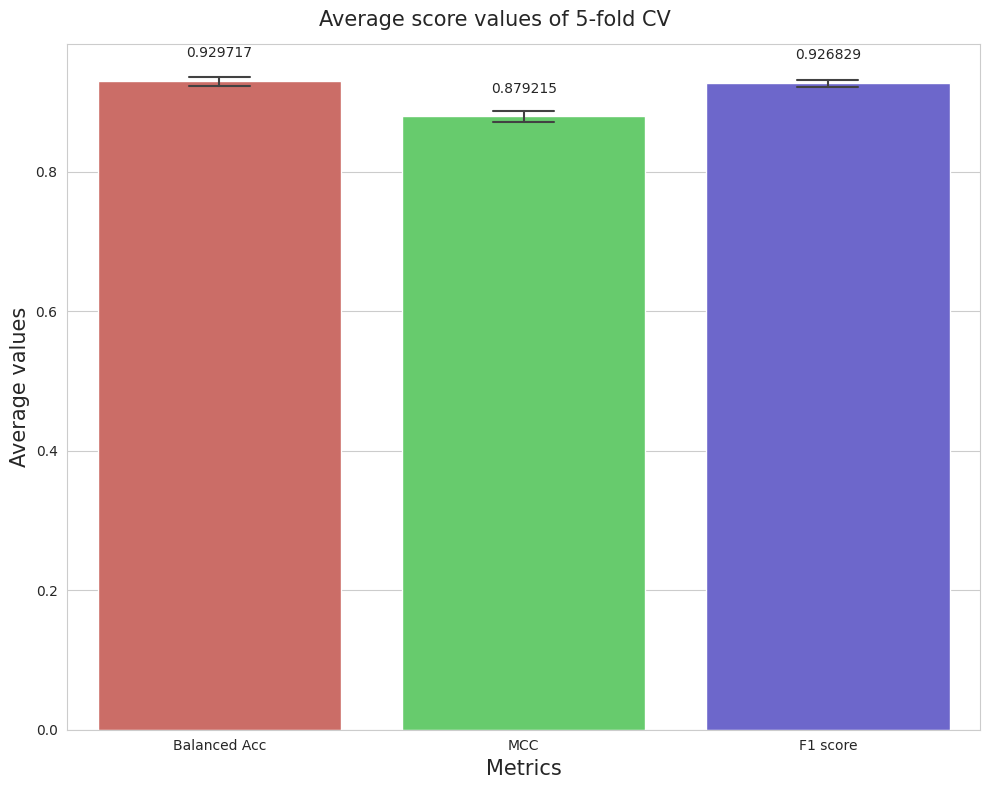

In [70]:

import pandas as pd

my_dict = {'Balanced Acc': [results_all[i]['valid_bal_acc'][results_all[i]['valid_loss'].index(min(results_all[i]['valid_loss']))] for i in range(len(results_all))], 
           'MCC': [results_all[i]['valid_mcc'][results_all[i]['valid_loss'].index(min(results_all[i]['valid_loss']))] for i in range(len(results_all))], 
           'F1 score': [results_all[i]['valid_f_score'][results_all[i]['valid_loss'].index(min(results_all[i]['valid_loss']))] for i in range(len(results_all))]}

my_df = pd.DataFrame(my_dict)
print(my_df)
plt.rcParams["figure.autolayout"] = True
plt.figure(figsize=(10,8))
sns.set_style('whitegrid')
ax = sns.barplot(data= my_df, estimator=np.mean, color='blue', palette='hls', errorbar="sd", capsize=.2, errwidth=1.5)
ax.bar_label(ax.containers[0], padding=15)

plt.xlabel('Metrics', fontsize=15)
plt.ylabel(f'Average values', fontsize=15)

plt.suptitle(f'Average score values of 5-fold CV', fontsize=15)
plt.savefig(f'/kaggle/working/efficientNet_cv_scores.png')
plt.show()

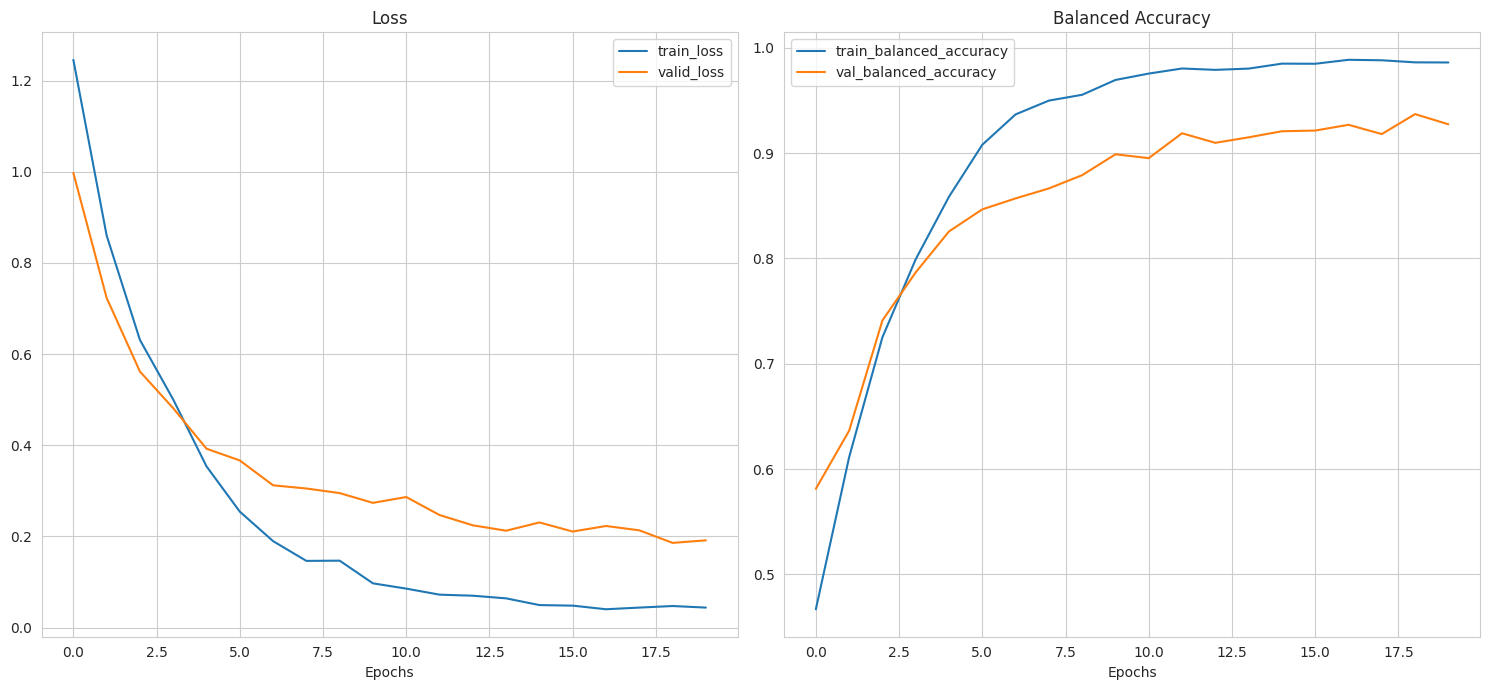

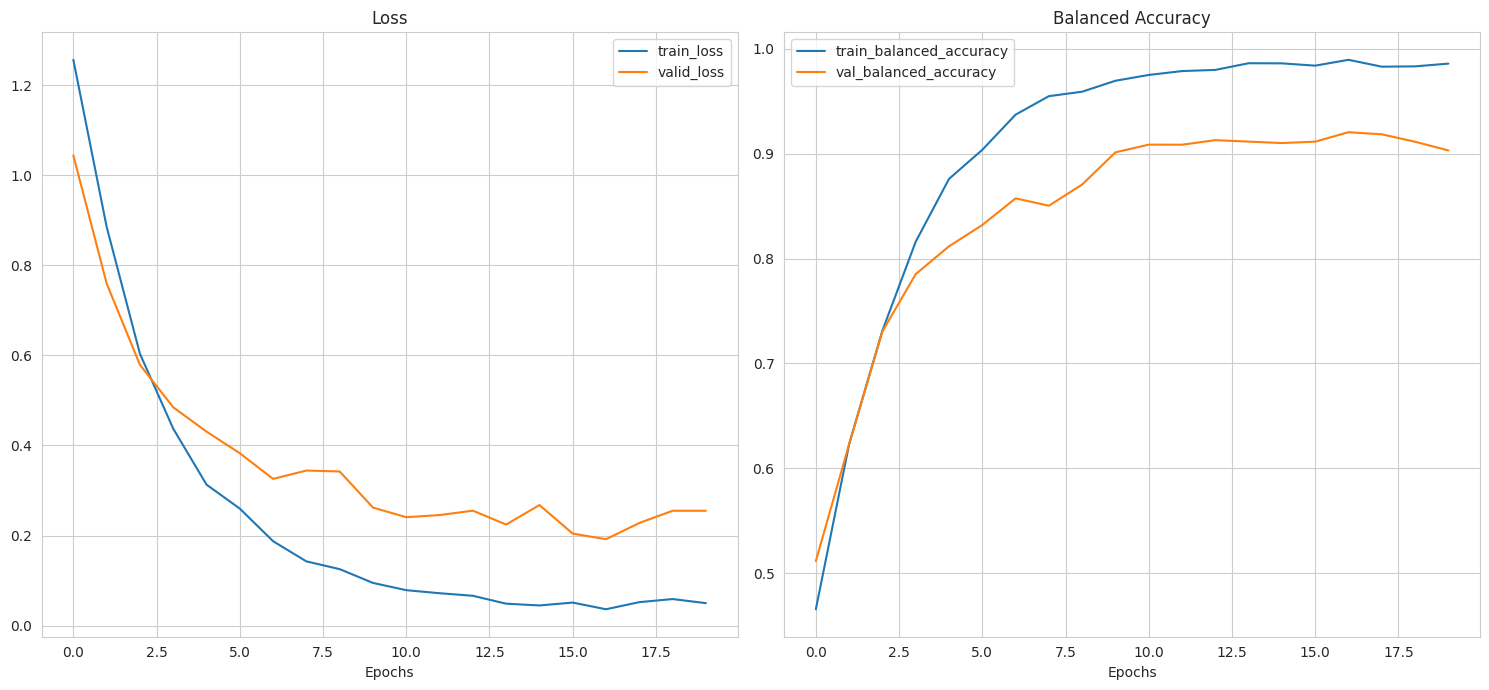

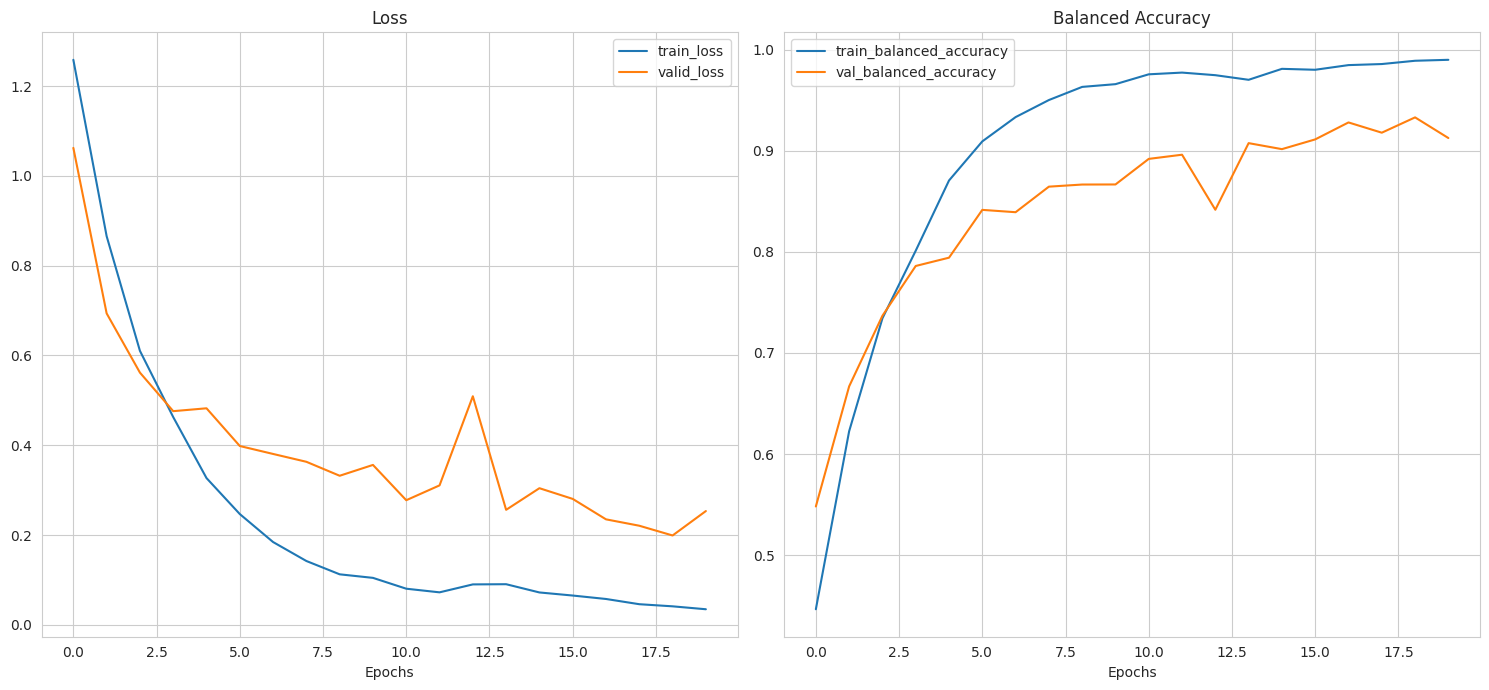

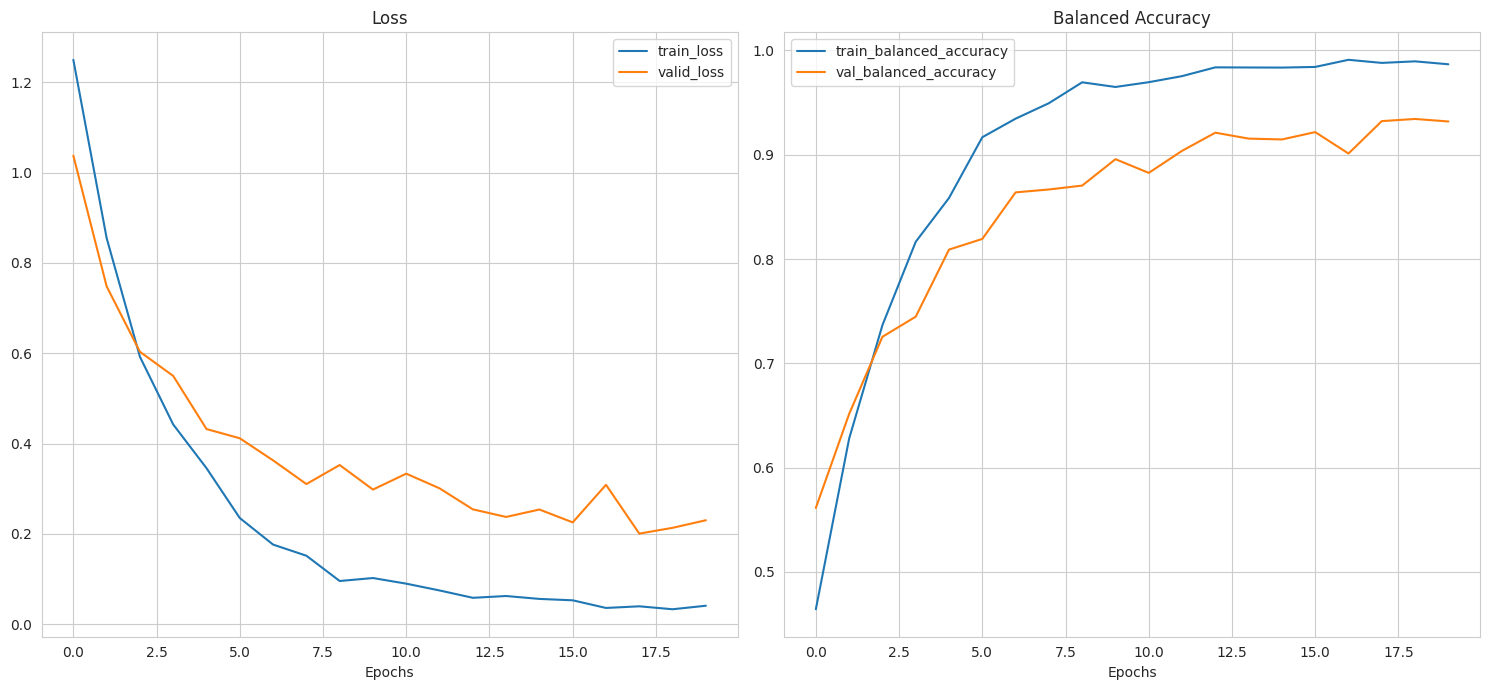

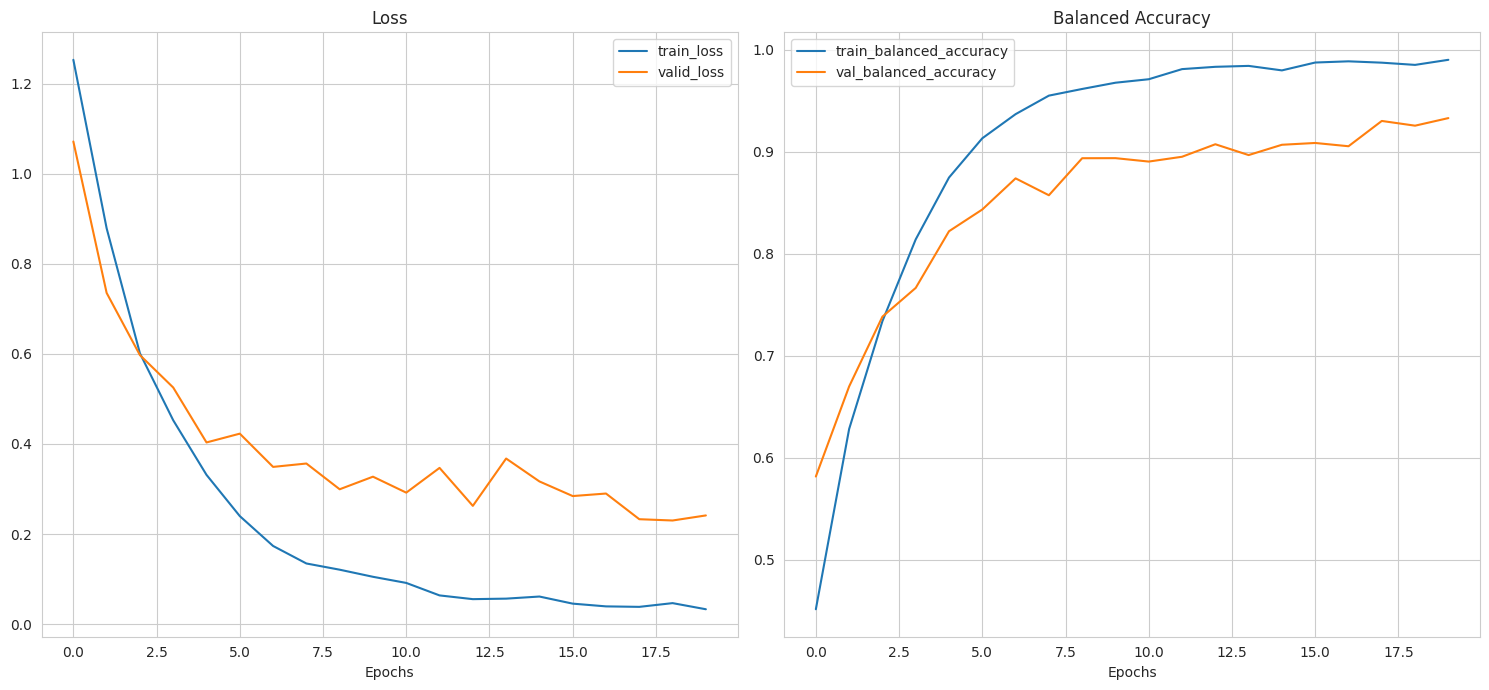

In [71]:
# Plot the loss curves of our model
for i in range(len(results_all)):
    helper_functions.plot_loss_curves(results_all[i])
    plt.savefig(f'/kaggle/working/efficientNet_loss_curves_split_{i}.png')

# Final model

Train a final model and evaluate it on the held out test set

Start Training of final model


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2392 | train_bal_acc: 0.4605 | train_mcc: 0.2266 | valid_loss: 1.0039 | valid_bal_acc: 0.5705 | valid_mcc: 0.3178
Epoch: 2 | train_loss: 0.8186 | train_bal_acc: 0.6372 | train_mcc: 0.3971 | valid_loss: 0.7504 | valid_bal_acc: 0.6537 | valid_mcc: 0.4260
Epoch: 3 | train_loss: 0.6236 | train_bal_acc: 0.7174 | train_mcc: 0.4982 | valid_loss: 0.5739 | valid_bal_acc: 0.7163 | valid_mcc: 0.5380
Epoch: 4 | train_loss: 0.4593 | train_bal_acc: 0.8040 | train_mcc: 0.6267 | valid_loss: 0.4550 | valid_bal_acc: 0.7926 | valid_mcc: 0.6177
Epoch: 5 | train_loss: 0.3453 | train_bal_acc: 0.8645 | train_mcc: 0.7135 | valid_loss: 0.4005 | valid_bal_acc: 0.8388 | valid_mcc: 0.6728
Epoch: 6 | train_loss: 0.2579 | train_bal_acc: 0.9044 | train_mcc: 0.7990 | valid_loss: 0.4134 | valid_bal_acc: 0.8159 | valid_mcc: 0.7052
Epoch: 7 | train_loss: 0.2135 | train_bal_acc: 0.9258 | train_mcc: 0.8451 | valid_loss: 0.4381 | valid_bal_acc: 0.8449 | valid_mcc: 0.6996
Epoch: 8 | train_loss: 0.14

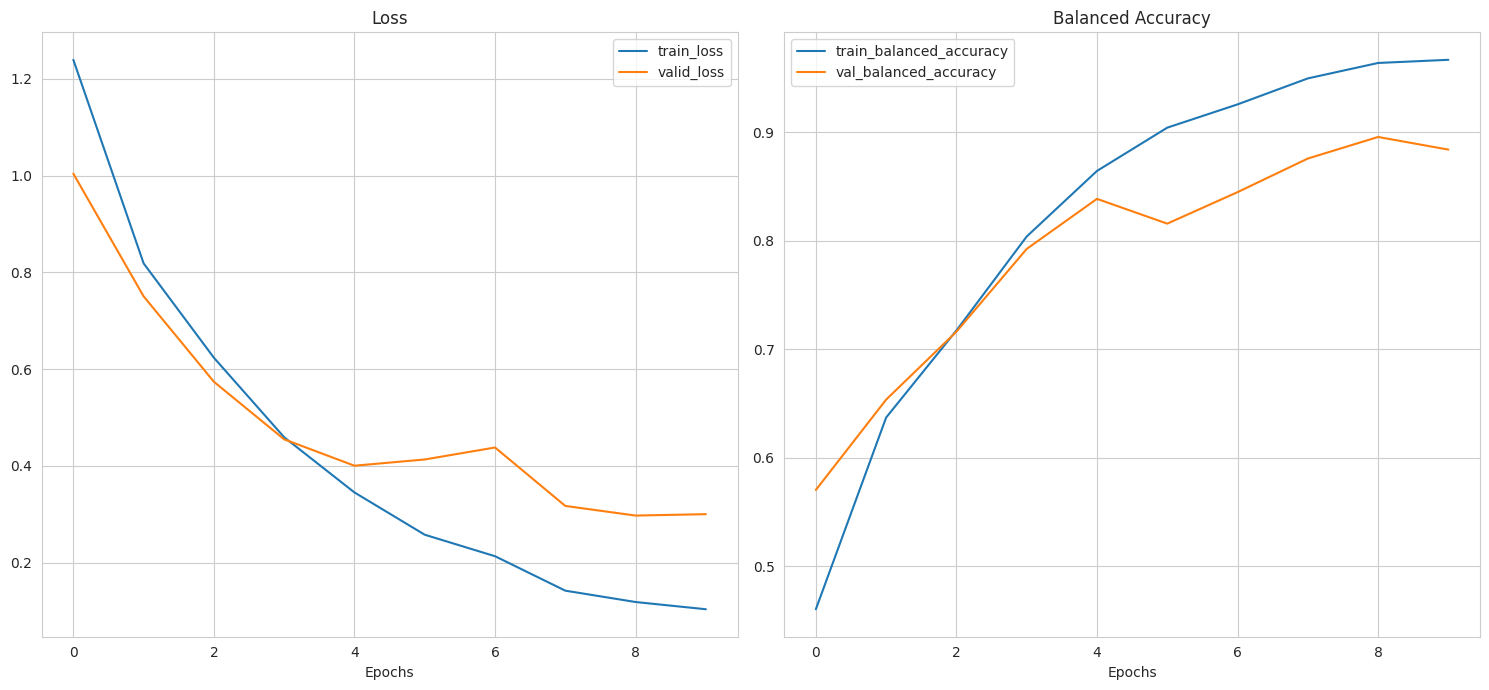

In [72]:
# train final model on the reduced set with a split 85-15 train-val
reduced_dataset = train_subset
train_indices, val_indices = train_test_split(train_idx, test_size=0.20, stratify=train_targets, random_state=42)  # set seed to ensure reproducibility
                                              
train_subset = Subset(train_dataset, train_indices)
train_targets=[train_dataset.targets[i] for i in train_indices]
                                              
val_subset = Subset(train_dataset, val_indices)
val_targets=[train_dataset.targets[i] for i in val_indices]
                                              
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
                                              
                                              
start_time = timer()


# Create default model
model=create_efficientnetb1_custom(num_classes).to(device)

# Set the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


print('Start Training of final model')
results, final_model = engine.train_with_early_stopping(model=model,
                                              train_dataloader=train_loader,
                                              valid_dataloader=val_loader,
                                              optimizer=optimizer,
                                              loss_fn=loss_fn,
                                              epochs=10,
                                              device=device)


end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds\n")

MODEL_SAVE_PATH = os.path.join('/kaggle/working/', '01_efficientnet_final_model.pth')
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=final_model.state_dict(), f=MODEL_SAVE_PATH)
                                              
helper_functions.plot_loss_curves(results)
plt.savefig(f'/kaggle/working/training_curves_efficientnet_final_model.png')

## Test final model on the held out test set

In [73]:
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, f1_score
import torch.nn.functional as F


final_model.eval()


with torch.inference_mode():
    all_predictions = []
    all_true_labels = []
    all_test_pred_prob=[]
    
    test_loss, test_bal_acc, test_mcc, test_f_score = 0, 0, 0, 0
    for batch, (X, y) in enumerate(test_loader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = final_model(X)

        # 2. Calculate and accumulate loss
        loss = loss_fn(test_pred_logits, y)
        test_loss += loss.item()

        # Calculate and accumulate scores
        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_pred_prob = torch.softmax(test_pred_logits.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)
        test_bal_acc += balanced_accuracy_score(y.cpu().numpy(), test_pred_labels.cpu().numpy())
        test_mcc += matthews_corrcoef(y.cpu().numpy(), test_pred_labels.cpu().numpy())
        test_f_score += f1_score(y.cpu().numpy(), test_pred_labels.cpu().numpy(), average='weighted')
        
        all_predictions.extend(test_pred_labels.cpu().numpy())
        all_true_labels.extend(y.cpu().numpy())
        all_test_pred_prob.extend(test_pred_prob.cpu().numpy())

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(test_loader)
    test_bal_acc = test_bal_acc / len(test_loader)
    test_mcc = test_mcc / len(test_loader)
    test_f_score = test_f_score / len(test_loader)
    print(f'Test loss: {test_loss} | Test bal acc {test_bal_acc} | Test mcc {test_mcc} | Test_f_score {test_f_score}\n')   
    



Test loss: 0.29472943050786854 | Test bal acc 0.8853037035776973 | Test mcc 0.7824701369789991 | Test_f_score 0.8625395669079958



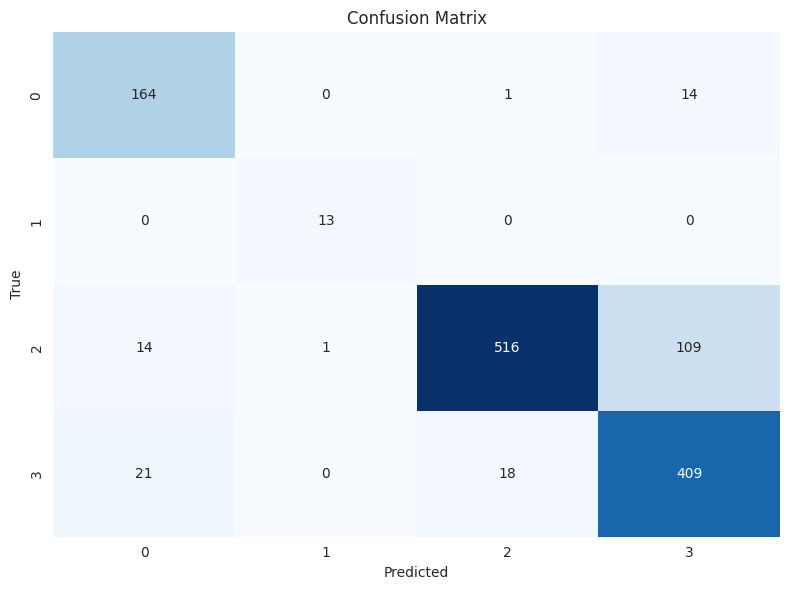

In [74]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(all_true_labels, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(f'/kaggle/working/efficientNet_final_model_cm.png', dpi=300)
plt.show()


In [76]:
# Generate the classification report
report = classification_report(all_true_labels, all_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       179
           1       0.93      1.00      0.96        13
           2       0.96      0.81      0.88       640
           3       0.77      0.91      0.83       448

    accuracy                           0.86      1280
   macro avg       0.87      0.91      0.89      1280
weighted avg       0.88      0.86      0.86      1280



# Train final model with data augmentations on the train set

In [48]:
# Define train and val transformations
train_transforms = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

test_transforms = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [90]:
# Reload training data with augmentations
#train_indices, val_indices = train_test_split(train_idx, test_size=0.15, stratify=train_targets, random_state=42)

train_dataset = ImageFolder(DATA_DIR, transform=train_transforms)
val_dataset = ImageFolder(DATA_DIR, transform=val_transforms)

train_subset = Subset(train_dataset, train_indices)
train_targets=[train_dataset.targets[i] for i in train_indices]
                                              
val_subset = Subset(val_dataset, val_indices)
val_targets=[train_dataset.targets[i] for i in val_indices]
                                              
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

Start Training of final model with train data augmentations


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2425 | train_bal_acc: 0.4624 | train_mcc: 0.2172 | valid_loss: 1.0073 | valid_bal_acc: 0.5834 | valid_mcc: 0.3704
Epoch: 2 | train_loss: 0.8465 | train_bal_acc: 0.6373 | train_mcc: 0.3906 | valid_loss: 0.6863 | valid_bal_acc: 0.6931 | valid_mcc: 0.4741
Epoch: 3 | train_loss: 0.5630 | train_bal_acc: 0.7484 | train_mcc: 0.5361 | valid_loss: 0.6118 | valid_bal_acc: 0.7405 | valid_mcc: 0.5518
Epoch: 4 | train_loss: 0.4138 | train_bal_acc: 0.8341 | train_mcc: 0.6663 | valid_loss: 0.4589 | valid_bal_acc: 0.8036 | valid_mcc: 0.6355
Epoch: 5 | train_loss: 0.3004 | train_bal_acc: 0.8872 | train_mcc: 0.7664 | valid_loss: 0.3848 | valid_bal_acc: 0.8318 | valid_mcc: 0.7379
Epoch: 6 | train_loss: 0.2069 | train_bal_acc: 0.9296 | train_mcc: 0.8478 | valid_loss: 0.3505 | valid_bal_acc: 0.8704 | valid_mcc: 0.7867
Epoch: 7 | train_loss: 0.1467 | train_bal_acc: 0.9500 | train_mcc: 0.8912 | valid_loss: 0.3045 | valid_bal_acc: 0.8755 | valid_mcc: 0.7648
Epoch: 8 | train_loss: 0.10

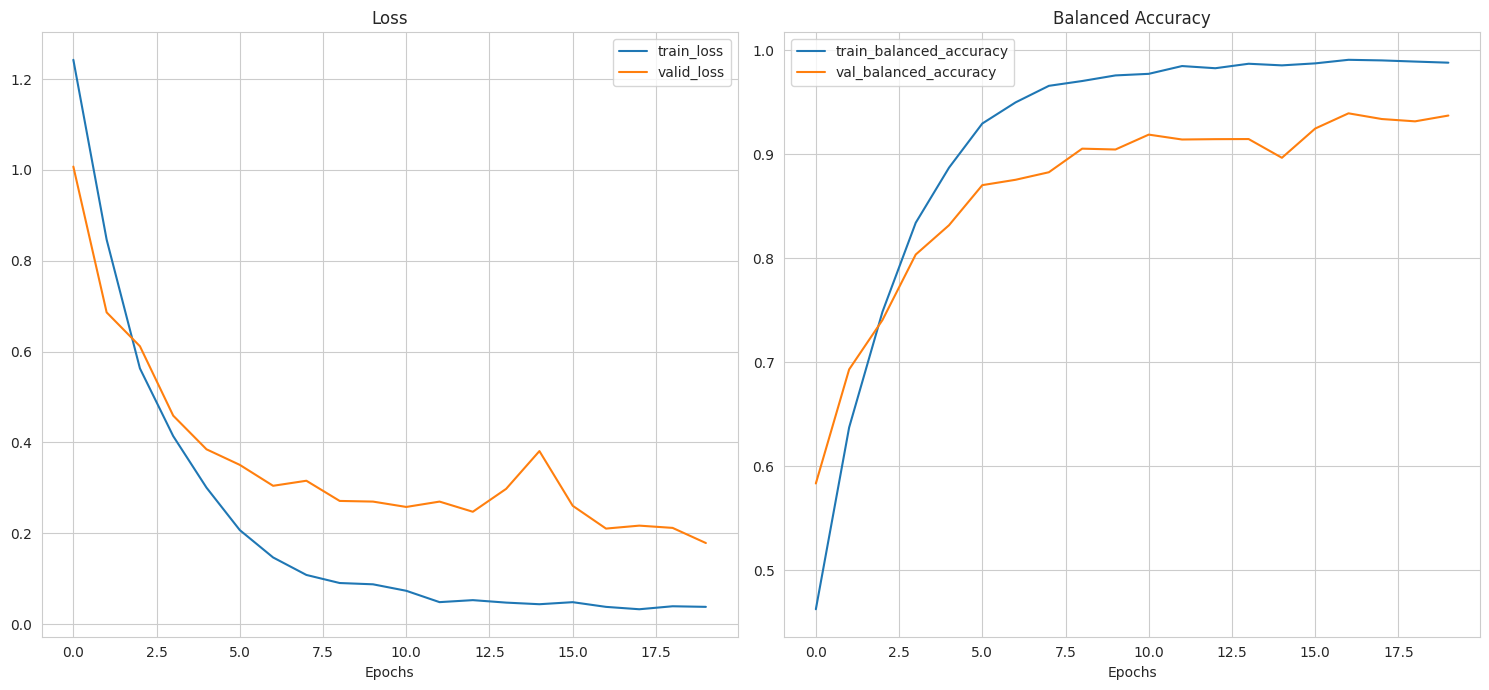

In [33]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()


model_2aug = create_efficientnetb1_custom(num_classes).to(device)
## if we want to continue training our final model with the augmented training set then: 
# model_2aug=final_model

# Set the optimizer
optimizer = torch.optim.Adam(model_2aug.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.01)

print('Start Training of final model with train data augmentations')
results_aug, final_model_aug = engine.train_with_early_stopping(model=model_2aug,
                                                          train_dataloader=train_loader,
                                                          valid_dataloader=val_loader,
                                                          optimizer=optimizer,
                                                          loss_fn=loss_fn,
                                                          epochs=20,
                                                          device=device)


end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds\n")

MODEL_SAVE_PATH = os.path.join('/kaggle/working/', '02_EfficientNEtb0_final_model_augment.pth')
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=final_model_aug.state_dict(), f=MODEL_SAVE_PATH)
                                              
helper_functions.plot_loss_curves(results_aug)
plt.savefig(f'/kaggle/working/training_curves_EfficientNEtb0_final_model_augment.png')

# Test final model trained with data augmentations on the held out test set

In [34]:
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, f1_score

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model=final_model_aug

model.eval()
with torch.inference_mode():
    all_predictions = []
    all_true_labels = []
    
    test_loss, test_bal_acc, test_mcc, test_f_score = 0, 0, 0, 0
    for batch, (X, y) in enumerate(test_loader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model(X)

        # 2. Calculate and accumulate loss
        loss = loss_fn(test_pred_logits, y)
        test_loss += loss.item()

        # Calculate and accumulate scores
        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_bal_acc += balanced_accuracy_score(y.cpu().numpy(), test_pred_labels.cpu().numpy())
        test_mcc += matthews_corrcoef(y.cpu().numpy(), test_pred_labels.cpu().numpy())
        test_f_score += f1_score(y.cpu().numpy(), test_pred_labels.cpu().numpy(), average='weighted')
        
        all_predictions.extend(test_pred_labels.cpu().numpy())
        all_true_labels.extend(y.cpu().numpy())

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(test_loader)
    test_bal_acc = test_bal_acc / len(test_loader)
    test_mcc = test_mcc / len(test_loader)
    test_f_score = test_f_score / len(test_loader)
    print(f'Test loss: {test_loss} | Test bal acc {test_bal_acc} | Test mcc {test_mcc} | Test_f_score {test_f_score}\n')   
    

Test loss: 0.1671501390170306 | Test bal acc 0.9418861085487439 | Test mcc 0.8751188519594274 | Test_f_score 0.9229334504868996



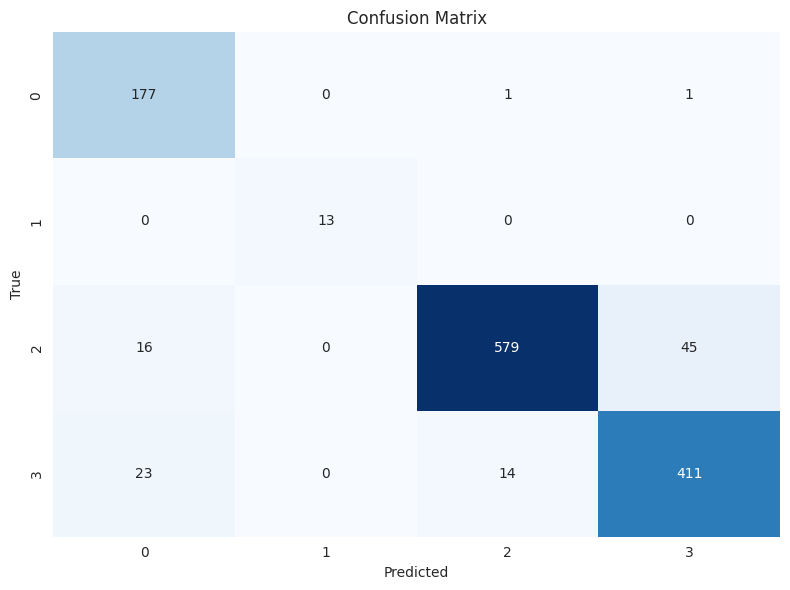

In [35]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(all_true_labels, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(f'/kaggle/working/EfficietnNetb0_final_model_aug_cm.png', dpi=300)
plt.show()

In [36]:
# Generate the classification report
report = classification_report(all_true_labels, all_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.82      0.99      0.90       179
           1       1.00      1.00      1.00        13
           2       0.97      0.90      0.94       640
           3       0.90      0.92      0.91       448

    accuracy                           0.92      1280
   macro avg       0.92      0.95      0.94      1280
weighted avg       0.93      0.92      0.92      1280



# Load saved model from working directory

In [37]:
# Define your model
loaded_model = custom_efficientnet 

# Define the path to the weights file
weights_file_path = MODEL_SAVE_PATH

# Check if the weights file exists and load them while mapping to CPU
if os.path.exists(weights_file_path):
    state_dict = torch.load(weights_file_path, map_location=torch.device('cpu'))
    custom_efficientnet.load_state_dict(state_dict)
    print("Weights loaded successfully.")
else:
    print(f"Weights file not found at {weights_file_path}. Model initialized with default weights.")


Weights loaded successfully.


# Visualizing predictions


## Create a function for plotting images and predictions


In [5]:
# model=loaded_model

In [45]:
# 1. Take in a trained model, class names, dataset, image size, a transform, and target device
def pred_and_plot_image(model: torch.nn.Module,
                        dataset: torch.utils.data.Dataset,  # Assuming a custom dataset class
                        class_names: List[str],
                        image_size: Tuple[int, int] = (240, 240),
                        transform: transforms.Compose = None,
                        number_of_images=5,
                        device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    
    # 2. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = test_transforms

    ### Predict on images from the dataset ### 

    # 3. Make sure the model is on the target device
    model.to(device)

    # 4. Turn on model evaluation mode
    model.eval()

    # 5. Iterate through the dataset and make predictions
    for i in range(number_of_images):
        image, label = dataset[i]  # Assuming your dataset returns (image, label) pairs

        # 6. Send the image tensor to the target device
        image = image.to(device)

        # 7. Make a prediction on the image
        with torch.no_grad():
            target_image_pred = model(image.unsqueeze(0))  # Add a batch dimension

        # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
        target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

        # 9. Convert prediction probabilities -> prediction label
        target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1).item()

        # 10. Plot the image tensor with predicted label and probability
        plt.figure()
        plt.imshow(image.cpu().numpy().squeeze().transpose(1, 2, 0))  # Convert tensor to NumPy array
        plt.title(f"True: {class_names[label]}, Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
        plt.axis(False)


In [46]:
# Create list with class names
class_names=['MildDemented',
 'ModerateDemented',
 'NonDemented',
 'VeryMildDemented']

## Plot some predictions

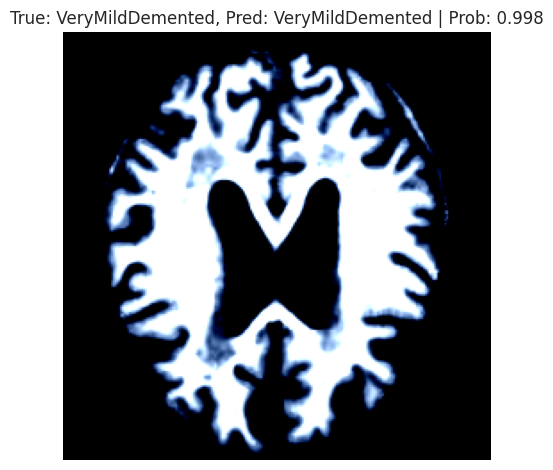

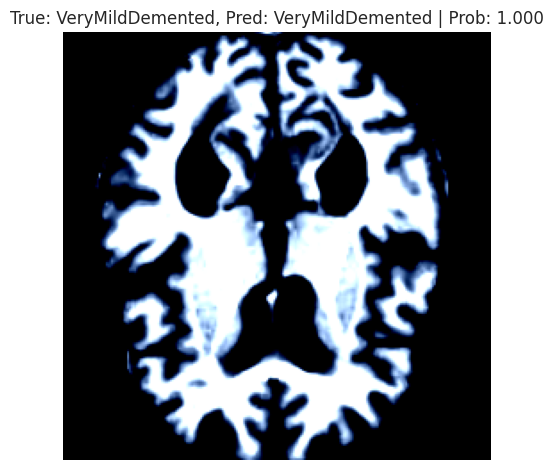

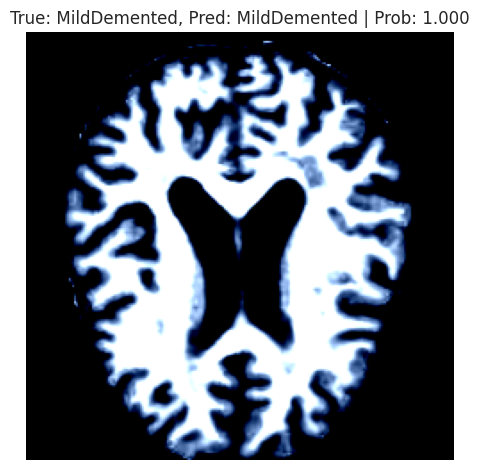

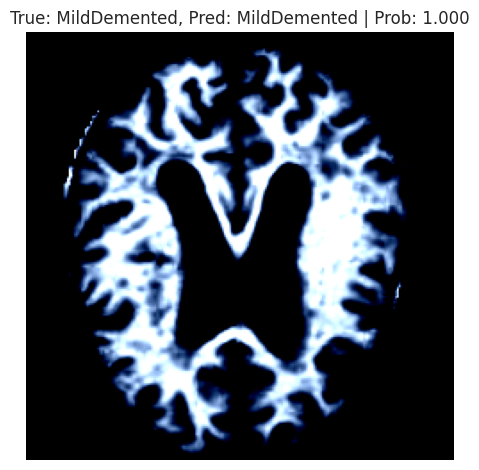

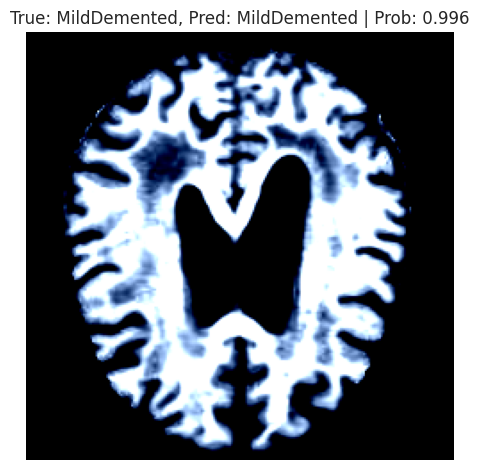

In [49]:
# Plot some predictions
pred_and_plot_image(model, test_subset, class_names, image_size=(240, 240))


## Plot some wrong predictions

In [50]:
# Find the images of the test_subset that have been classifies wrong
wrong_indices = [i for i in range(len(all_true_labels)) if all_true_labels[i] != all_predictions[i]]
wrong_set=[test_subset[i] for i in wrong_indices]


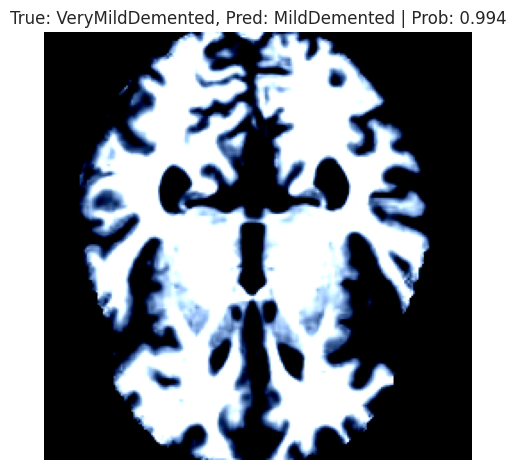

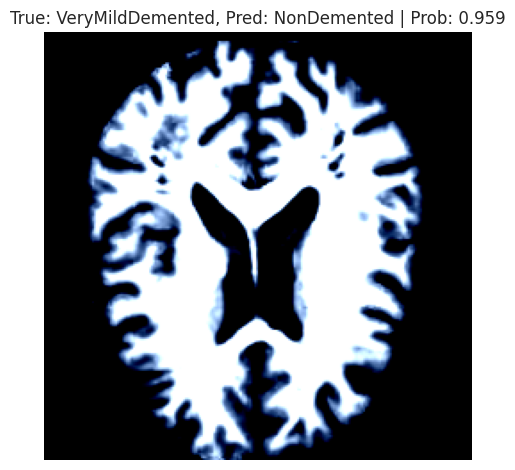

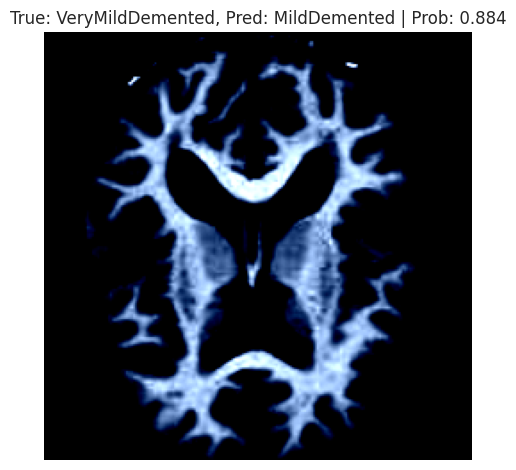

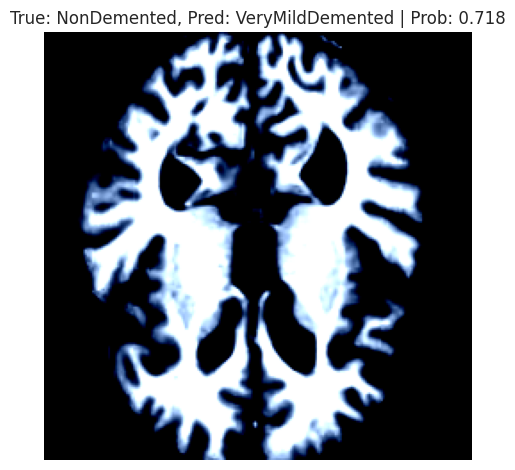

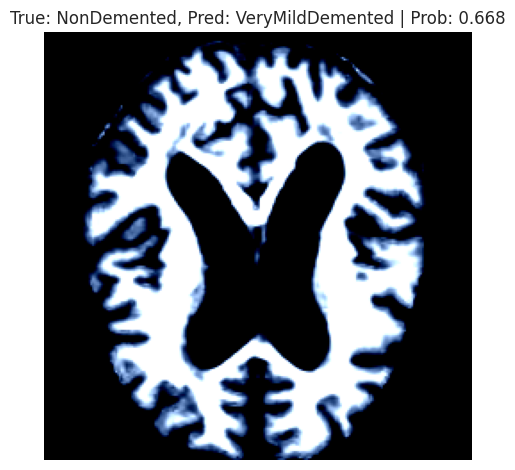

In [51]:
# Plot wrongly classified images with probabilies
pred_and_plot_image(model, wrong_set, class_names, image_size=(224, 224))

# Model Explainability using GradCam

In [52]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 20.8 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.0-py3-none-any.whl size=38070 sha256=1bcc94b05a9c3979e73476f4e52b0defd8bb5194dd1846d49da486332b008904
  Stored in directory: /root/.cache/pip/wheels/5b/e5/3d/8548241d5cffe53ad1476c566a61ad9bf09cc61a9430f09726
Successfully built grad-cam


In [53]:
from pytorch_grad_cam import GradCAM
from PIL import Image

from torchvision.transforms.functional import to_tensor
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

import cv2 

In [55]:
model=loaded_model

In [63]:
from torchvision.transforms import Compose, ToTensor, Normalize
import torch

def preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    preprocessing = Compose([
        ToTensor(),
        Normalize(mean=mean, std=std)
    ])

    # Check if the image is grayscale (single channel)
    if img.ndim == 3:
        img = cv2.merge([img, img, img])  # Convert to 3-channel grayscale
    
    img = np.float32(img) / 255  # Move this line after handling grayscale
    
    return preprocessing(img.copy()).unsqueeze(0)

# ... (rest of your code)

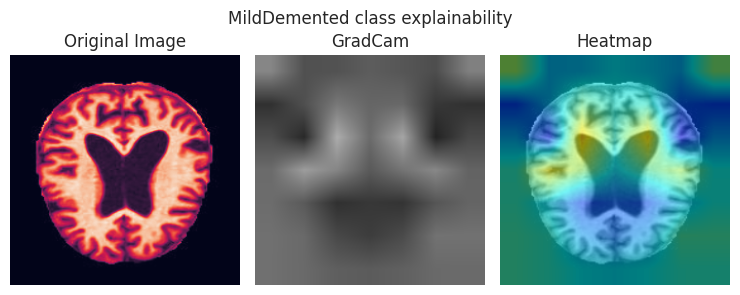

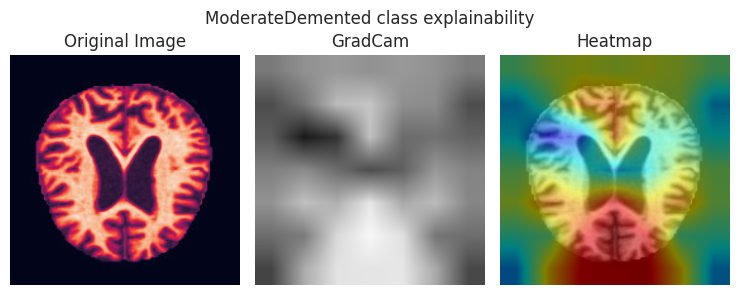

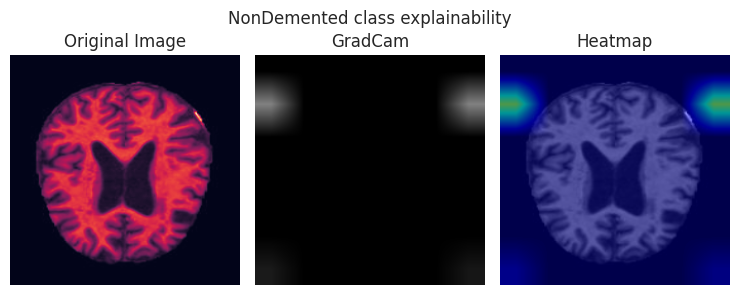

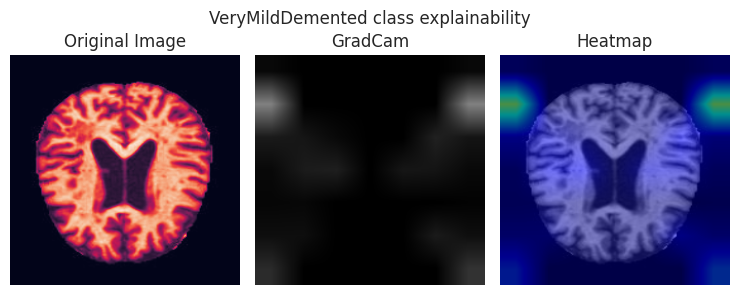

In [65]:


image_filenames = ['/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/MildDemented/26 (21).jpg',
                   '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/29 (2).jpg',
                   '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/VeryMildDemented/26 (46).jpg',
                   '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/NonDemented/26 (65).jpg'

                  ]

target_layer = model.features[-1] # this is the target layer that we want grad cam to use its feature map and generate the Grad-CAM heatmaps

def show(imgs, title):
    sub_plot_titles = ['Original Image', 'GradCam', 'Heatmap']
    if not isinstance(imgs, list):
        imgs = [imgs]
        
    plt.rcParams["figure.figsize"] = [7.50, 3]
    fig, axs = plt.subplots(1, len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        axs[0, i].imshow(img)
        axs[0, i].set_title(sub_plot_titles[i])
        axs[0, i].grid(False)
        axs[0, i].axis('off')
        
    fig.suptitle(title)
    plt.grid(False)
    plt.axis('off')
    plt.show()
    
    
def reshape_transform(tensor, height=14, width=14):
    # This function transforms the tensors of Vit to use them with Grad Cam similarly as the results of CNN models
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result
    
    
def visualize_gradcam(model, layer, device, filenames, vit=False):
    for idx, class_name in enumerate(['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']):
        model.eval()

        img = np.array(Image.open(filenames[idx]))
        img = cv2.resize(img, (224, 224))
        img = np.float32(img) / 255
        img = np.expand_dims(img, axis=-1)
        input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        if device == 'cuda':
            use_cuda = True
        else:
            use_cuda = False

        # The target for the CAM is the class of each image.
        # As usual for classication, the target is the logit output
        # before softmax, for that category.
        target_layers = [layer]
        targets = [ClassifierOutputTarget(idx)] 
        
        if vit:
            with GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform) as cam:
                grayscale_cams = cam(input_tensor=input_tensor.to(device), targets=targets, aug_smooth=True)
                cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
        else:
            with GradCAM(model=model, target_layers=target_layers) as cam:
                grayscale_cams = cam(input_tensor=input_tensor.to(device), targets=targets, aug_smooth=True)
                cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)

        cam = np.uint8(255*grayscale_cams[0, :])
        cam = cv2.merge([cam, cam, cam])
        # images = np.hstack((np.uint8(255*img), cam , cam_image))
        images = [np.uint8(255*img), cam , cam_image]
        show(images, f'{class_name} class explainability')
        # Image.fromarray(images)
        
visualize_gradcam(model, target_layer, device, image_filenames)